### This notebook contains dashboard ready code for plots and natural language summaries of 3 tested XAI techniques.

1. Tree Path Analysis
2. TreeSHAP
3. Reconstruction Error Attribution

Install required python libraries

In [1]:
import tensorflow as tf
from tensorflow import keras


print("TensorFlow imported successfully!")
print(f"TensorFlow version: {tf.__version__}") # Print version to double-check

TensorFlow imported successfully!
TensorFlow version: 2.10.1


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.ensemble import IsolationForest
from sklearn.tree import _tree
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.client import device_lib
import joblib
from tqdm import tqdm
import time
import random
import shap
from utils.find_root import find_project_root

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Retrieve the project root dynamically and set it as working directory
project_root = find_project_root()
os.chdir(project_root)

Load the data

Load sequence and inference data

In [5]:
# seq_start_times = np.load('/content/drive/MyDrive/Data Science MSC/v2XAIHANDOFF/xai_handoff_v2/lstm_sequences/seq_start_times_train.npy',allow_pickle=True)
df = pd.read_csv('outputs/modelling/inference/inference_20250531_1700.csv')

In [ ]:
anomaly_label = df['anomaly_label']

Load the Isolation Forest model

In [6]:
if_model = joblib.load('outputs/modelling/models/if_model.joblib')

In [7]:
if_features = ['temperature_2m_z', 'surface_pressure_z', 'wind_r', 'precip_z_12h', 'precip_z_24h']

Load the LSTM-Autoencoder model

In [8]:
sequence_data = 'outputs/modelling/inference/lstm_sequences.npy'

X = np.load(sequence_data)

print(X.shape)

(793, 720, 8)


In [9]:
snapshot_data = pd.read_csv('outputs/modelling/inference/inference_20250531_1700.csv')

### Data exploration

Data summary

In [10]:
print(df.head())

                  date  temperature_2m  surface_pressure  precipitation  \
0  2025-05-31 17:00:00            23.0            1011.4            0.0   
1  2025-05-31 18:00:00            21.9            1011.2            0.0   
2  2025-05-31 19:00:00            21.1            1010.8            0.0   
3  2025-05-31 20:00:00            20.1            1010.9            0.0   
4  2025-05-31 21:00:00            18.7            1011.7            0.0   

   wind_speed_10m  precip_log  wind_smoothed  temperature_2m_z  \
0            24.1         0.0      24.100000          1.981413   
1            24.8         0.0      24.450000          1.748538   
2            25.2         0.0      24.700000          1.579173   
3            15.8         0.0      21.933333          1.367468   
4            18.4         0.0      19.800000          1.071081   

   surface_pressure_z    wind_r  ...      hour_cos  month_sin  month_cos  \
0           -0.440185  1.727468  ... -2.588190e-01        0.5  -0.866025   


In [11]:
snapshot_data.head()

,date,temperature_2m,surface_pressure,precipitation,wind_speed_10m,precip_log,wind_smoothed,temperature_2m_z,surface_pressure_z,wind_r,...,hour_cos,month_sin,month_cos,if_score,is_if_anomaly,lstm_error,is_lstm_anomaly,if_threshold,lstm_threshold,anomaly_label
0,2025-05-31 17:00:00,23.0,1011.4,0.0,24.1,0.0,24.100000,1.981413,-0.440185,1.727468,...,-2.588190e-01,0.5,-0.866025,0.162669,0,0.680835,1,0.033044,0.6425,Pattern anomaly
1,2025-05-31 18:00:00,21.9,1011.2,0.0,24.8,0.0,24.450000,1.748538,-0.467940,1.772532,...,-1.836970e-16,0.5,-0.866025,0.169193,0,0.644328,1,0.033044,0.6425,Pattern anomaly
2,2025-05-31 19:00:00,21.1,1010.8,0.0,25.2,0.0,24.700000,1.579173,-0.523450,1.804721,...,2.588190e-01,0.5,-0.866025,0.167394,0,0.668963,1,0.033044,0.6425,Pattern anomaly
3,2025-05-31 20:00:00,20.1,1010.9,0.0,15.8,0.0,21.933333,1.367468,-0.509572,1.448498,...,5.000000e-01,0.5,-0.866025,0.200375,0,0.507134,0,0.033044,0.6425,Normal
4,2025-05-31 21:00:00,18.7,1011.7,0.0,18.4,0.0,19.800000,1.071081,-0.398553,1.173820,...,7.071068e-01,0.5,-0.866025,0.234645,0,0.508397,0,0.033044,0.6425,Normal


Loading the autoencoder

In [12]:
autoencoder = load_model("outputs/modelling/models/lstm_ae_best.h5")

## XAI Technique 1: Tree Path Analysis


Tree structure

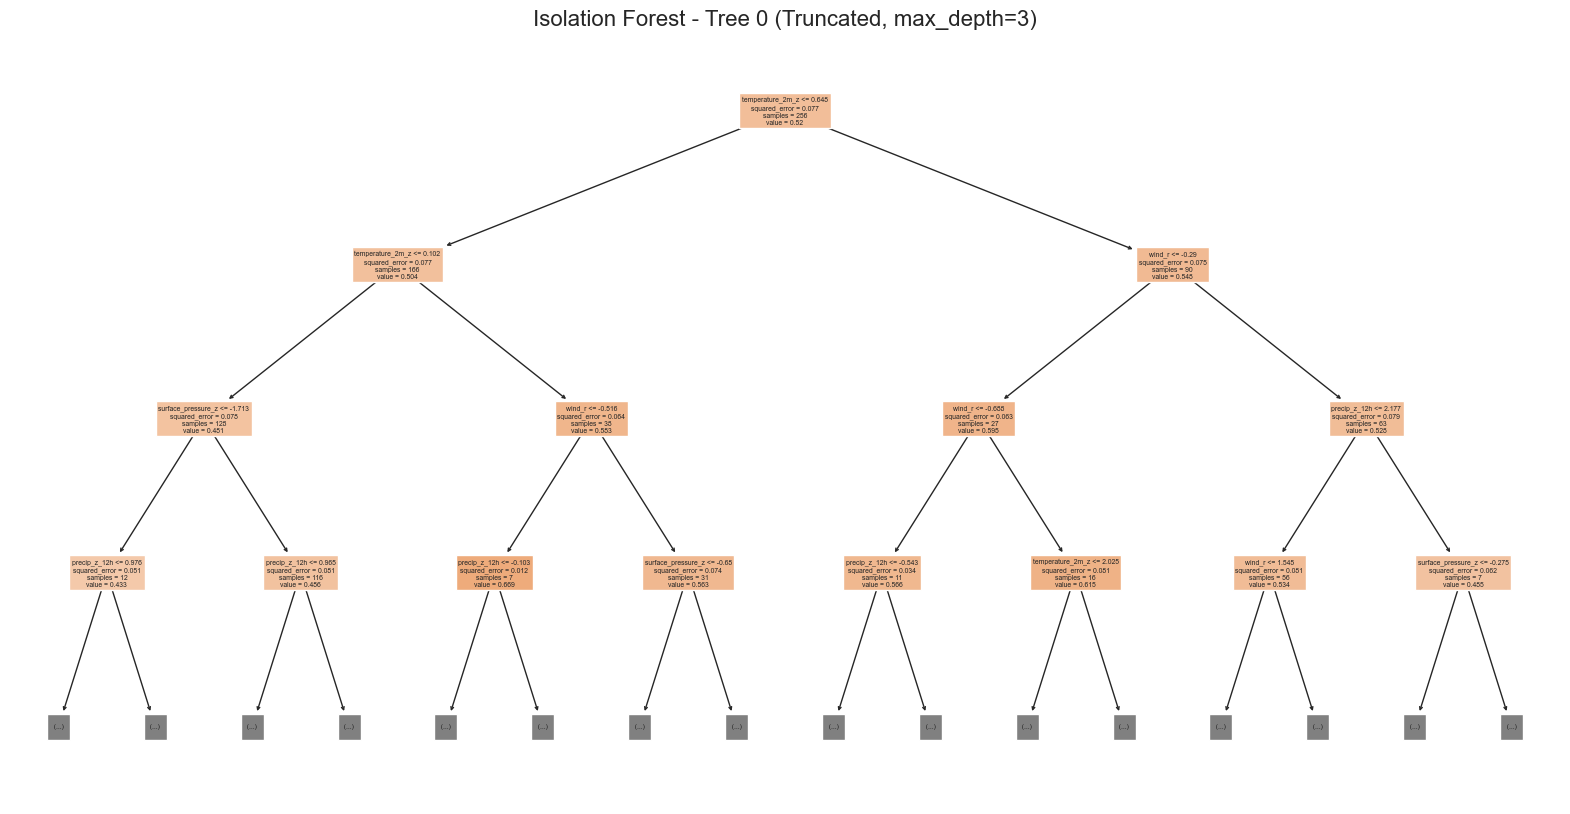

In [13]:
tree_index_to_plot = 0 # first tree in the ensemble- change index to change which tree is visualisaed

if tree_index_to_plot < len(if_model.estimators_):
    selected_tree = if_model.estimators_[tree_index_to_plot]

    plt.figure(figsize=(20, 10))
    plot_tree(selected_tree, feature_names=if_features, filled=True, max_depth=3)  # Limit max_depth for readability

    plt.title(f"Isolation Forest - Tree {tree_index_to_plot} (Truncated, max_depth=3)", fontsize=16)
    plt.show()
else:
    print(f"Error: Tree index {tree_index_to_plot} is out of bounds. The model has {len(if_model.estimators_)} trees (indices 0 to {len(if_model.estimators_)-1}).")


Path length of a single sample

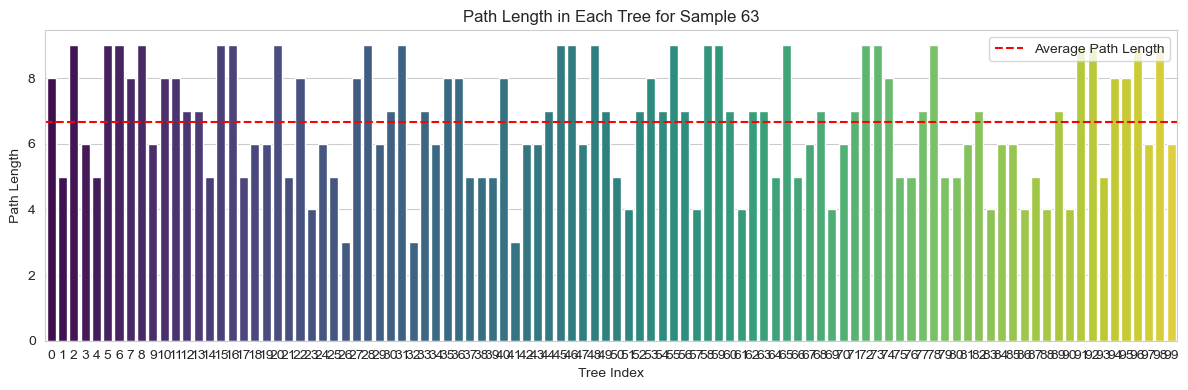

In [14]:
sample_index = 63 # change to select a different sample

# Select the sample data for the Isolation Forest features
X_sample = df[if_features].iloc[[sample_index]]

# Calculate the path length for this sample in each tree
path_lengths = []
for tree in if_model.estimators_:
    # tree.decision_path returns a sparse matrix indicating the path nodes
    path = tree.decision_path(X_sample)
    # number of nodes visited (number of non-zero entries in the sparse matrix)
    path_lengths.append(path.nnz)

# Now path_lengths is defined and contains the path length for the sample in each tree

plt.figure(figsize=(12, 4))
sns.barplot(x=np.arange(len(path_lengths)), y=path_lengths, palette="viridis")
plt.axhline(np.mean(path_lengths), color='red', linestyle='--', label='Average Path Length')
plt.xlabel("Tree Index")
plt.ylabel("Path Length")
plt.title(f"Path Length in Each Tree for Sample {sample_index}")
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
# calculating and storing decision paths for each sample through each tree in the Isolation Forest
paths_per_tree = []

for tree in if_model.estimators_:

    snapshot_df = df[if_features]
    path_matrix_tree = tree.decision_path(snapshot_df)
    paths_per_tree.append(path_matrix_tree)

print(f"Number of trees processed: {len(paths_per_tree)}")
print(f"Shape of path matrix for the first tree: {paths_per_tree[0].shape}")

Number of trees processed: 100
Shape of path matrix for the first tree: (72, 169)


In [16]:
# identifying which features were used in splits

def tree_path_features(tree, x):
    tree_ = tree.tree_
    feature = tree_.feature
    threshold = tree_.threshold

    node = 0
    path_features = []

    while tree_.feature[node] != _tree.TREE_UNDEFINED:
        split_feature = feature[node]
        path_features.append(split_feature)
        if x[split_feature] <= threshold[node]:
            node = tree_.children_left[node]
        else:
            node = tree_.children_right[node]

    return path_features


### XAI visualisations & natural language summaries

Feature importance


Represents how frequently each feature was used for splitting decisions along paths taken by analyzed samples

In [17]:
# calculating and visualising TPA scores for each sample in the snapshot

# Dictionary to store feature counts for each sample
all_sample_feature_counts = {}

for i, row in snapshot_df.iterrows():
    # Dictionary to store feature counts for the current sample
    feature_counts = {}

    # Iterate through each tree in the Isolation Forest model
    for estimator in if_model.estimators_:
        features_used = tree_path_features(estimator, row[if_features].values)

        # Count how many times each feature's index was used in the path
        for f in features_used:

            fname = if_features[f]
            feature_counts[fname] = feature_counts.get(fname, 0) + 1

    # Store the feature counts for the current sample, indexed by the original sample index
    all_sample_feature_counts[i] = feature_counts

# Convert the dictionary of feature counts into a DataFrame
# Each row corresponds to a sample (original index), columns are features, values are counts
tpa_df = pd.DataFrame.from_dict(all_sample_feature_counts, orient='index')

tpa_df = tpa_df.fillna(0)

# Normalize the counts: Divide the counts for each feature by the total number of trees
# This gives the proportion of trees where a feature was used in the sample's path
tpa_df = tpa_df / len(if_model.estimators_)



FIRST XAI EXPORT

Generating natural language summaries and visualisations for each sample based on TPA scores

In [18]:
import os
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd

# Paths
original_csv_path = "outputs/modelling/inference/inference_20250531_1700.csv"
output_csv_path = "outputs/xai/tpa-treeshap-rea.csv"
plot_output_dir = "outputs/xai/plots"

os.makedirs(plot_output_dir, exist_ok=True)

# Load the original CSV as a copy
df = pd.read_csv(original_csv_path)


# Initialize new columns for summaries and plot paths
df['tpa_summary'] = ""
df['tpa_plot_path'] = ""

for original_sample_index in snapshot_df.index:

    if original_sample_index not in df.index:
        print(f"Warning: Sample index {original_sample_index} not found in base df")
        continue

    label = df.loc[original_sample_index, "anomaly_label"]

    # Define label descriptions
    if label.lower() == "compound anomaly":
        label_description = (
            "🔺 This sample was flagged as a **Compound Anomaly**, meaning both sub-models detected unusual patterns. "
            "This may suggest a more credible anomaly, but should still be reviewed in context."
        )
        what_happened = (
            "The sample exhibits multiple unusual characteristics detected by both models."
        )
        why_happened = (
            "The combined flags indicate consistent unusual activity across different feature subsets."
        )
        what_to_do = (
            "Consider prioritizing this sample for further investigation or mitigation."
        )
    elif label.lower() == "normal":
        label_description = (
            "✅ This sample was classified as **Normal**, meaning the model found no significant deviations in the data."
        )
        what_happened = "The sample shows normal behavior with no flagged anomalies."
        why_happened = "The features fell within expected ranges based on training data."
        what_to_do = "No immediate action is required."
    else:
        label_description = (
            f"⚠️ This sample was labeled as **{label}**, flagged by only one detection model."
        )
        what_happened = (
            "The model identified some unusual patterns but only from a single perspective."
        )
        why_happened = (
            "This could be due to isolated irregularities or potential model sensitivity."
        )
        what_to_do = (
            "Further review is advised to confirm whether this is a true anomaly."
        )

    summary = ""
    plot_filepath = ""

    if original_sample_index in tpa_df.index:
        sample_tpa_scores = tpa_df.loc[original_sample_index]
        sample_tpa_scores_sorted = sample_tpa_scores.sort_values(ascending=False)

        top_features = sample_tpa_scores_sorted.head(2)
        summary = (
            f"--- Sample Index: {original_sample_index} | Label: {label} ---\n"
            f"🧠 Tree Path Analysis shows these top features influenced the model's decision:\n"
        )
        for feature, score in top_features.items():
            summary += f"- **{feature.replace('_', ' ').capitalize()}** (importance: {score:.2f})\n"

        summary += (
            f"\nWhat happened?\n{what_happened}\n\n"
            f"Why did it happen?\n{why_happened}\n\n"
            f"What can we do about it?\n{what_to_do}\n\n"
            f"{label_description}"
        )

        # Save plot
        plt.figure(figsize=(10, 6))
        sample_tpa_scores_sorted.plot(kind="barh", color="teal")
        plt.title(f"Tree Path Analysis\nSample Index: {original_sample_index} | Label: {label}", fontsize=14)
        plt.xlabel("Normalized Split Count (Across Trees)", fontsize=12)
        plt.ylabel("Feature", fontsize=12)
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.tight_layout()

        plot_filename = f"tpa_sample_{original_sample_index}.png"
        plot_filepath = os.path.join(plot_output_dir, plot_filename)
        plt.savefig(plot_filepath)
        plt.close()
    else:
        summary = "No Tree Path Analysis data available for this sample."
        plot_filepath = ""

    # Save summary and plot path into the copy dataframe
    df.at[original_sample_index, 'tpa_summary'] = summary
    df.at[original_sample_index, 'tpa_plot_path'] = plot_filepath

# Save the updated DataFrame copy as a new CSV file
df.to_csv(output_csv_path, index=False)
print(f"✅ Updated CSV saved as a COPY to: {output_csv_path}")



✅ Updated CSV saved as a COPY to: outputs/xai/tpa-treeshap-rea.csv


XAI Technique 2: TreeSHAP

Global overview of feature importance

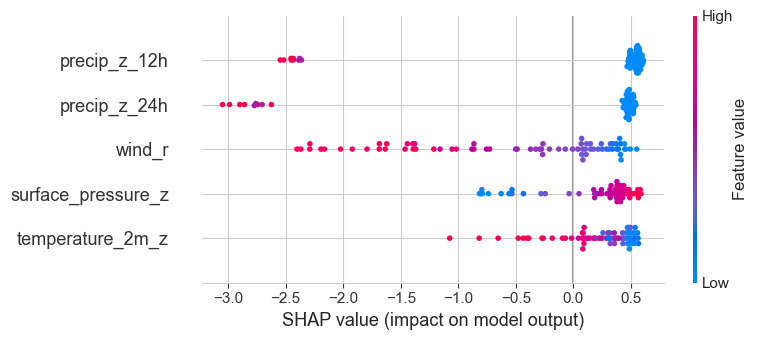

In [19]:
X_if = df[if_features]

explainer = shap.TreeExplainer(if_model)

shap_values = explainer.shap_values(X_if)

shap.summary_plot(shap_values, X_if)

Average SHAP value for each feature

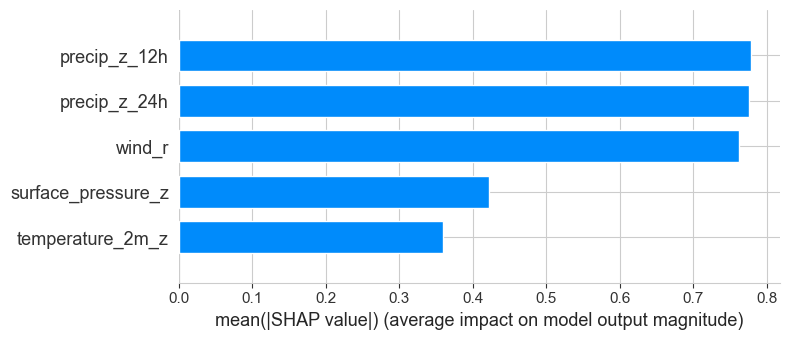

In [20]:
shap.summary_plot(shap_values, X_if, plot_type="bar")


Feature dependence plots

Generating dependence plot for feature: temperature_2m_z


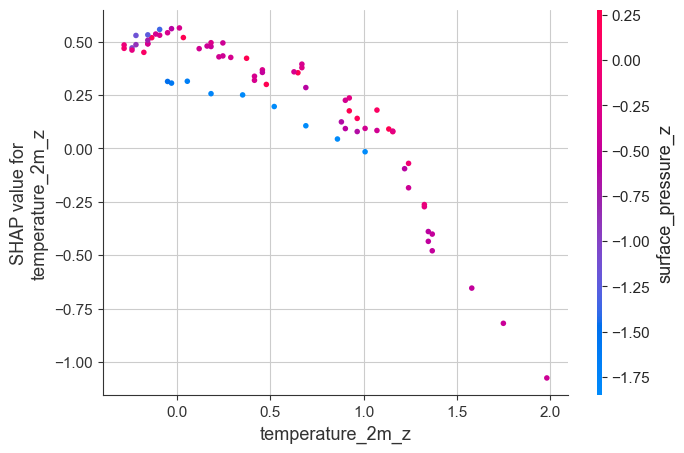

Generating dependence plot for feature: surface_pressure_z


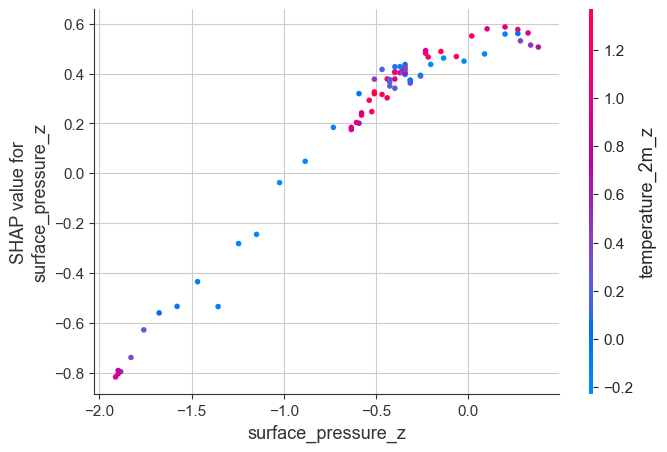

Generating dependence plot for feature: wind_r


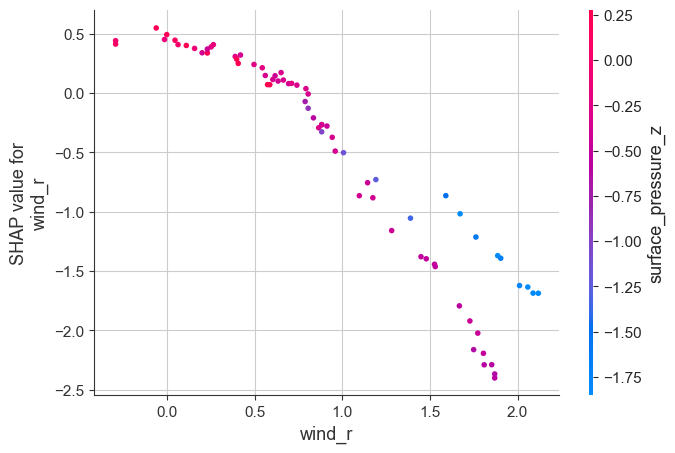

Generating dependence plot for feature: precip_z_12h


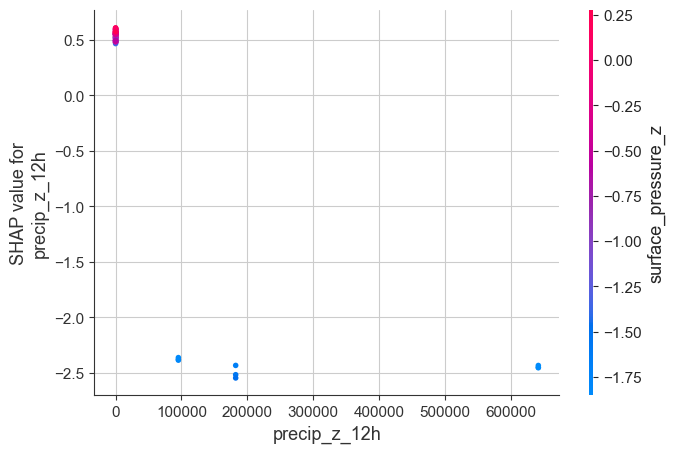

Generating dependence plot for feature: precip_z_24h


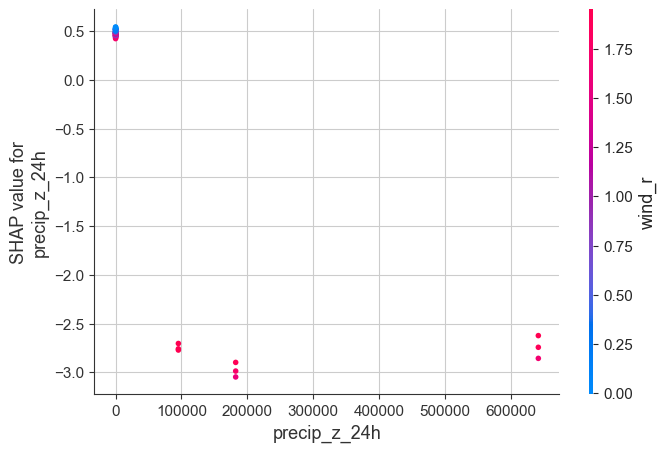

In [21]:
for feature_name in if_features:
    print(f"Generating dependence plot for feature: {feature_name}")


    shap.dependence_plot(
        feature_name,
        shap_values,
        X_if
    )

    plt.show()

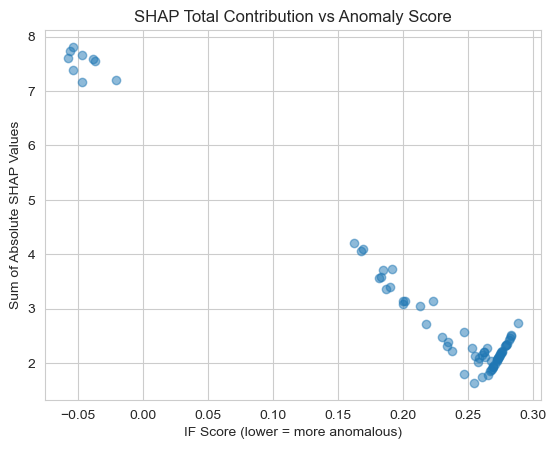

In [22]:
if_scores = if_model.decision_function(X_if)

df.loc[X_if.index, "if_score"] = if_scores

import matplotlib.pyplot as plt

total_shap = np.abs(shap_values).sum(axis=1)

plt.scatter(df.loc[X_if.index, "if_score"], total_shap, alpha=0.5)
plt.xlabel("IF Score (lower = more anomalous)")
plt.ylabel("Sum of Absolute SHAP Values")
plt.title("SHAP Total Contribution vs Anomaly Score")
plt.show()

## Global summmary

In [23]:
mean_abs_shap = np.abs(shap_values).mean(axis=0)
global_explainer = pd.DataFrame({
    "feature": if_features,
    "mean_abs_shap": mean_abs_shap
}).sort_values("mean_abs_shap", ascending=False)

In [24]:
top_global = global_explainer.head(3)

global_summary = "Across the dataset, the model considered the following features most important for detecting anomalies:\n"
for _, row in top_global.iterrows():
    global_summary += f"- {row['feature']}, with average contribution magnitude of {row['mean_abs_shap']:.4f}\n"

print(global_summary)

Across the dataset, the model considered the following features most important for detecting anomalies:
- precip_z_12h, with average contribution magnitude of 0.7794
- precip_z_24h, with average contribution magnitude of 0.7766
- wind_r, with average contribution magnitude of 0.7624



## Local Explanation (specific data points)

In [25]:
X_shap = df[if_features]

Generating force plot for sample with index: 63


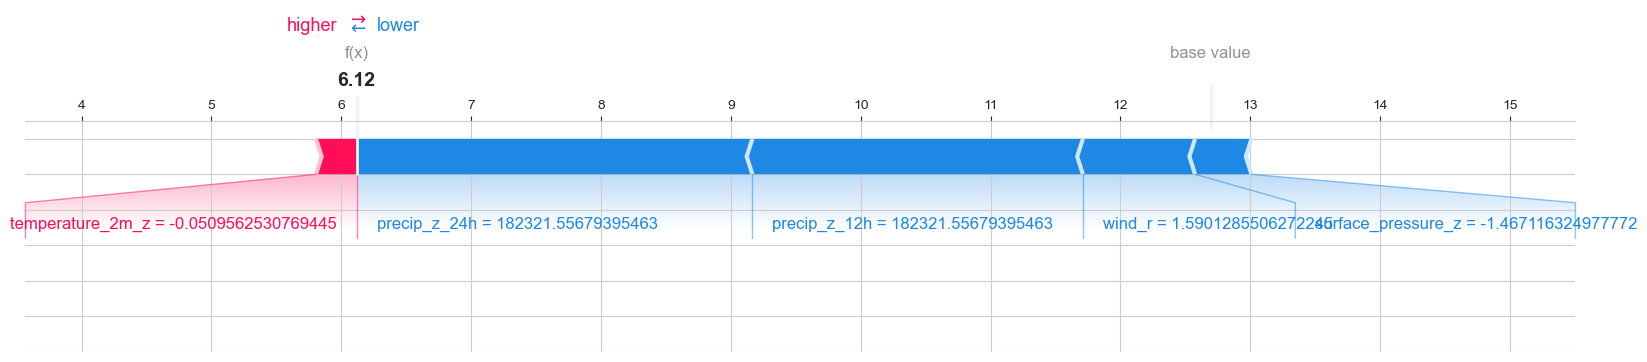

In [26]:
shap.initjs()


sample_index = 63

# Check if the sample index exists in the DataFrame
if sample_index in df.index:
    # Get the corresponding SHAP values for the selected sample
    # Use get_loc to find the integer position in the shap_values array
    sample_shap_index = df.index.get_loc(sample_index)
    current_shap_values = shap_values[sample_shap_index]

    # Get the actual feature values for the selected sample
    current_feature_values = X_if.loc[sample_index]

    print(f"Generating force plot for sample with index: {sample_index}")

    # Generate and display the force plot for the selected sample
    shap.force_plot(
        explainer.expected_value[0],
        current_shap_values,
        current_feature_values,
        matplotlib=True
    )

    plt.show()
else:
    print(f"Sample index {sample_index} not found in the DataFrame.")

Generating waterfall plot for sample with index: 63


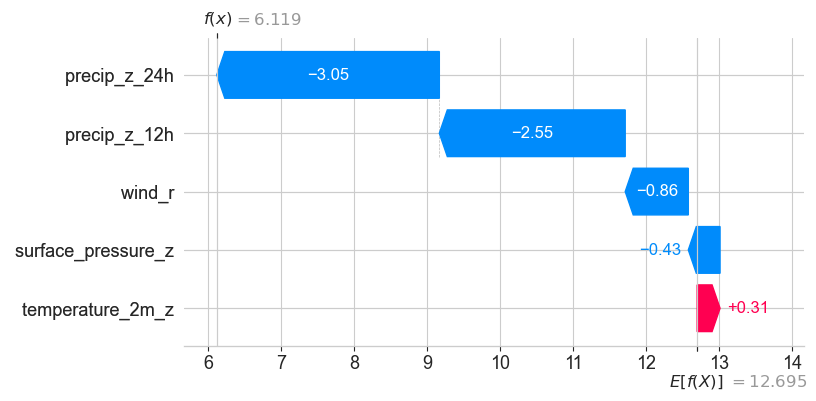

In [27]:

sample_index_to_plot = 63

# Check if the sample index exists in the DataFrame
if sample_index_to_plot in df.index:
    # Get the corresponding SHAP values for the selected sample
    # Use get_loc to find the integer position in the shap_values array
    sample_shap_index = df.index.get_loc(sample_index_to_plot)
    current_shap_values = shap_values[sample_shap_index]

    # Get the actual feature values for the selected sample
    current_feature_values = X_if.loc[sample_index_to_plot]

    print(f"Generating waterfall plot for sample with index: {sample_index_to_plot}")

    # Generate and display the waterfall plot for the selected sample
    shap.plots._waterfall.waterfall_legacy(
        explainer.expected_value[0],
        current_shap_values,
        current_feature_values
    )

    plt.show()
else:
    print(f"Sample index {sample_index_to_plot} not found in the DataFrame.")

Generating local feature contribution visualisations and natural language summaries for each sample

In [28]:
def plot_local_contribution(shap_values_sample, feature_values_sample, feature_names, anomaly_label, save_path=None):
    plt.figure(figsize=(10, 6))
    abs_shap = np.abs(shap_values_sample)
    sorted_indices = np.argsort(abs_shap)[::-1]
    sorted_features = np.array(feature_names)[sorted_indices]
    sorted_shap_values = shap_values_sample[sorted_indices]
    colors = ['#FF9999' if val < 0 else '#6699FF' for val in sorted_shap_values]
    plt.bar(sorted_features, sorted_shap_values, color=colors)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("SHAP value")
    plt.title(f"SHAP Local Contribution\nLabel: {anomaly_label}")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()

In [29]:
def generate_3_question_summary(expected_value, shap_vals, feature_vals, feature_names, anomaly_label):
    """
    Generate a summary that explicitly answers:
    1. What happened
    2. Why it happened
    3. Recommended next steps

    Args:
        expected_value (float): baseline for comparison.
        shap_vals (np.array): SHAP values for this sample.
        feature_vals (Series or np.array): actual feature values.
        feature_names (list of str): names of the features.
        anomaly_label (str): "normal", "point anomaly", etc.
    """
    # Sort by absolute SHAP
    idx_sorted = np.argsort(np.abs(shap_vals))[::-1]
    top_features = [((feature_names[idx], feature_vals[idx]), shap_vals[idx]) for idx in idx_sorted[:3]]

    what = f"What happened: The sample was classified as **{anomaly_label}**."

    reasons = "Why it happened: The following factors contributed most to this outcome:\n"
    for (feat, val), sh_val in top_features:
        direction = "increased" if sh_val > 0 else "decreased"
        reasons += f"- {feat} was {val}, which {direction} the likelihood of this outcome by {abs(sh_val):.2f}\n"

    if anomaly_label == "normal":
        recommended = "Recommended next steps: The conditions appear normal. Monitor regularly but no intervention is required."
    else:
        recommended = ("Recommended next steps: Investigate the factors contributing to this anomaly. "
                       "Consider validating sensor data or checking for unusual conditions in this area and time.")


    return f"{what}\n\n{reasons}\n{recommended}"

    reasons = "Why it happened: The following factors contributed most to this outcome:\n"
    for (feat, val), sh_val in top_features:
        direction = "increased" if sh_val > 0 else "decreased"
        reasons += f"- {feat} was {val}, which {direction} the likelihood of this outcome by {abs(sh_val):.2f}\n"

    if anomaly_label == "normal":
        recommended = "Recommended next steps: The conditions appear normal. Monitor regularly but no intervention is required."
    else:
        recommended = ("Recommended next steps: Investigate the factors contributing to this anomaly. "
                       "Consider validating sensor data or checking for unusual conditions in this area and time.")


    return f"{what}\n\n{reasons}\n{recommended}"

SECOND XAI EXPORT- APPENDS TO FIRST EXPORT CSV

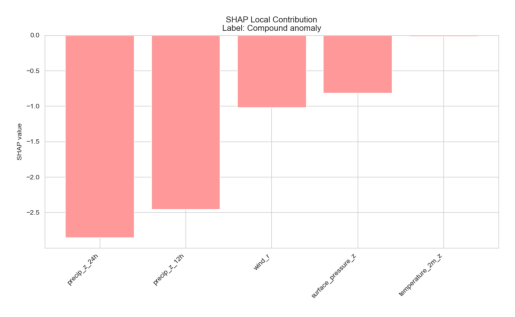

In [30]:
import os

plot_output_dir = "outputs/xai/plots"
os.makedirs(plot_output_dir, exist_ok=True)

# We'll store summaries and paths to assign to df later
summary_texts = []
plot_paths = []

for index, row in X_if.iterrows():
    anomaly_label = df.loc[index, "anomaly_label"]

    sample_shap_index = X_if.index.get_loc(index)
    current_shap_values = shap_values[sample_shap_index]
    current_feature_vals = row

    # Generate the 3-question summary
    summary = generate_3_question_summary(
        explainer.expected_value[0],
        current_shap_values,
        current_feature_vals,
        if_features,
        anomaly_label
    )
    summary_texts.append((index, summary))

    # Define plot filename and path
    plot_filename = f"treeshap_sample_{index}.png"
    plot_filepath = os.path.join(plot_output_dir, plot_filename)
    plot_paths.append((index, plot_filepath))

    # Generate and save the plot
    plot_local_contribution(
        current_shap_values,
        current_feature_vals,
        if_features,
        anomaly_label,
        save_path=plot_filepath  # Save to file
    )

    #print(f"Saved plot for sample {index} to: {plot_filepath}\n")

# Assign the new columns to df by index
for idx, summary_text in summary_texts:
    df.at[idx, "treeshap_summary"] = summary_text
for idx, path in plot_paths:
    df.at[idx, "treeshap_plot_path"] = path

# Save updated DataFrame to CSV, overwriting
output_csv_path = "outputs/xai/tpa-treeshap-rea.csv"
df.to_csv(output_csv_path, index=False)

--- Explanation for Sample Index: 63 ---

What happened: The sample was classified as **Compound anomaly**.

Why it happened: The following factors contributed most to this outcome:
- precip_z_24h was 182321.55679395463, which decreased the likelihood of this outcome by 3.05
- precip_z_12h was 182321.55679395463, which decreased the likelihood of this outcome by 2.55
- wind_r was 1.5901285506272245, which decreased the likelihood of this outcome by 0.86

Recommended next steps: Investigate the factors contributing to this anomaly. Consider validating sensor data or checking for unusual conditions in this area and time.

------------------------------

Plot for Sample Index: 63


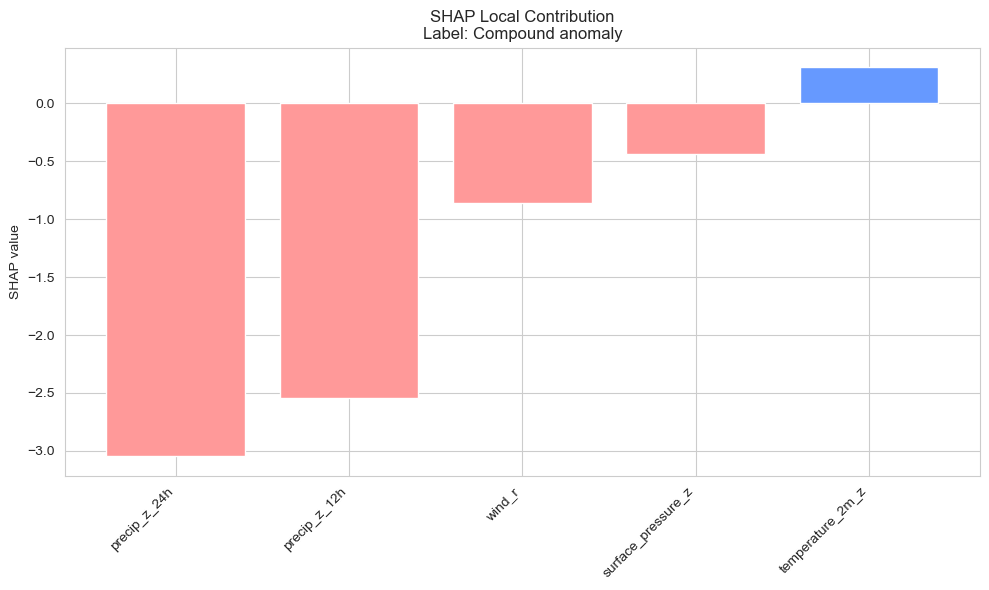

In [31]:
sample_index_to_display = 63

# Check if the sample index exists in the DataFrame
if sample_index_to_display in df.index:
    # Get the anomaly label for this specific sample
    anomaly_label = df.loc[sample_index_to_display, "anomaly_label"]

    # Get the corresponding SHAP values for the selected sample
    # Use get_loc to find the integer position in the shap_values array
    sample_shap_index = X_shap.index.get_loc(sample_index_to_display)
    current_shap_values = shap_values[sample_shap_index]

    # Get the actual feature values for the selected sample
    current_feature_vals = X_shap.loc[sample_index_to_display] # Use X_shap here

    # Generate the summary for the specific sample
    # Assuming generate_formatted_summary exists and works as before
    summary = generate_3_question_summary(
        explainer.expected_value[0],
        current_shap_values,
        current_feature_vals,
        if_features,
        anomaly_label
    )

    # --- Display the Summary and Plot ---

    from IPython.display import display, Markdown
    import matplotlib.pyplot as plt # Ensure this is imported

    display(Markdown(f"--- Explanation for Sample Index: {sample_index_to_display} ---"))
    display(Markdown(summary))
    display(Markdown("-" * 30))

    # Plot the SHAP contributions for the specific sample
    print(f"Plot for Sample Index: {sample_index_to_display}")
    # Assuming plot_local_contribution is defined elsewhere
    plot_local_contribution(
        current_shap_values,
        current_feature_vals,
        if_features,
        anomaly_label,
        save_path=None # Do not save, let plt.show() display
    )
    plt.show()

else:
    print(f"Sample index {sample_index_to_display} not found in the DataFrame.")

### XAI technique 3: Reconstruction Error Attribution

In [32]:
# Convert X to float32
X = np.array(X, dtype=np.float32)

# Predict the reconstruction using the loaded autoencoder model
# This is where X_reconstructed is first defined
X_reconstructed = autoencoder.predict(X)

# Now convert X_reconstructed to float32 (although predict usually returns float32)
# This line can now execute without NameError as X_reconstructed is defined
X_reconstructed = np.array(X_reconstructed, dtype=np.float32)

print("X and X_reconstructed are now defined and converted.")
print(f"Shape of X: {X.shape}, Dtype: {X.dtype}")
print(f"Shape of X_reconstructed: {X_reconstructed.shape}, Dtype: {X_reconstructed.dtype}")

25/25 [==============================] - 6s 82ms/step
X and X_reconstructed are now defined and converted.
Shape of X: (793, 720, 8), Dtype: float32
Shape of X_reconstructed: (793, 720, 8), Dtype: float32


25/25 [==============================] - 2s 76ms/step


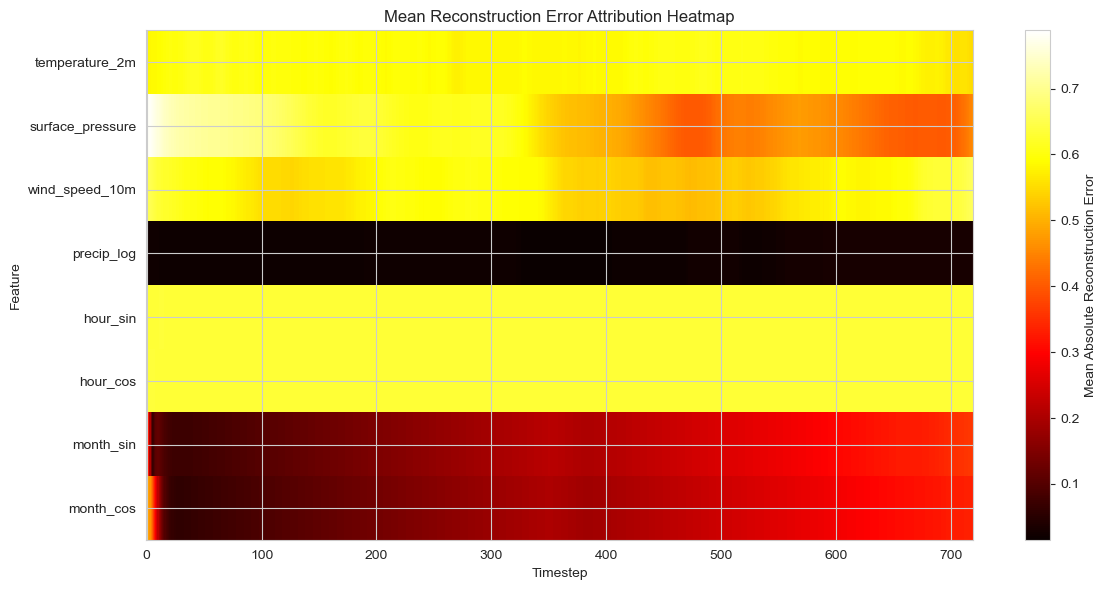

In [33]:

# 1. Predict reconstruction
X_reconstructed = autoencoder.predict(X)

# 2. Compute reconstruction error (element-wise absolute difference)
# Shape: (793, 720, 8)
reconstruction_error = np.abs(X - X_reconstructed)

# Shape: (720, 8)
mean_error = np.mean(reconstruction_error, axis=0)

# 3. Visualize as heatmap (time on x-axis, features on y-axis)
plt.figure(figsize=(12, 6))
plt.title("Mean Reconstruction Error Attribution Heatmap")
plt.xlabel("Timestep")
plt.ylabel("Feature")

required_features = [
    'temperature_2m', 'surface_pressure', 'wind_speed_10m', 'precip_log',
    'hour_sin', 'hour_cos', 'month_sin', 'month_cos'
]

if len(required_features) == mean_error.shape[1]:
    plt.yticks(np.arange(len(required_features)), required_features)
else:
    plt.yticks(np.arange(mean_error.shape[1]), [f"Feature {i}" for i in range(mean_error.shape[1])])
    print("Warning: Could not use required_features for y-axis labels. Check number of features.")

# Transpose so features are on y-axis and timesteps on x-axis
plt.imshow(mean_error.T, aspect='auto', cmap='hot', interpolation='nearest')
plt.colorbar(label='Mean Absolute Reconstruction Error')
plt.tight_layout()
plt.show()

FINAL XAI EXPORT- APPENDS TO SAME FILE

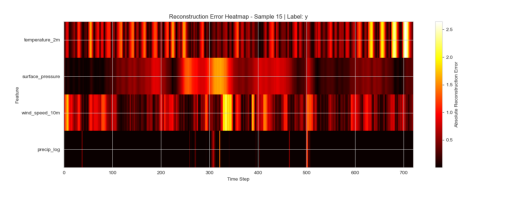

✅ Updated CSV saved to: outputs/xai/tpa-treeshap-rea.csv


In [34]:
import os
import matplotlib.pyplot as plt
import numpy as np

plot_output_dir = "outputs/xai/plots"
os.makedirs(plot_output_dir, exist_ok=True)


all_features = [
    'temperature_2m', 'surface_pressure', 'wind_speed_10m', 'precip_log',
    'hour_sin', 'hour_cos', 'month_sin', 'month_cos'
]

required_features = [
    'temperature_2m', 'surface_pressure', 'wind_speed_10m', 'precip_log'
]

selected_indices = [all_features.index(feat) for feat in required_features]
selected_features = required_features



# REA-specific explanation function
def generate_rea_summary(label="normal"):
    severity_mapping = {
        "normal": "No concern",
        "point anomaly": "Minor deviation (single-point irregularity)",
        "pattern anomaly": "Unusual behavior (pattern-level issue)",
        "compound anomaly": "Potential weather anomaly (multiple detection methods agree)"
    }

    severity_description = severity_mapping.get(label.lower(), "Unknown anomaly severity")

    what_happened = f"The sample was classified as **{label}** indicating {severity_description}."

    if label.lower() == "normal":
        why_happened = "The observed reconstruction errors are within expected ranges, showing no significant anomalies."
        recommended = "No action required; continue routine monitoring."
    else:
        why_happened = ("The reconstruction error deviated significantly from normal patterns, "
                        "indicating potential unusual weather events or data irregularities.")
        recommended = ("Review operational context (e.g., weather alerts, sensor data quality) "
                       "and consider further investigation of the anomaly.")

    return f"What happened:\n{what_happened}\n\nWhy it happened:\n{why_happened}\n\nRecommended next steps:\n{recommended}"

recon_error_summaries = []
recon_error_plot_paths = []

# Loop over all samples with available labels
for sample_index in range(len(anomaly_label)):
    sample_label = anomaly_label[sample_index]

    if sample_index >= len(reconstruction_error):
        print(f"Skipping sample {sample_index} — no reconstruction error data.")
        recon_error_summaries.append((sample_index, "No reconstruction error data available"))
        recon_error_plot_paths.append((sample_index, ""))
        continue

    # Use REA explanation generator
    explanation = generate_rea_summary(label=sample_label)
    recon_error_summaries.append((sample_index, explanation))

    # Prepare heatmap data
    sample_error = reconstruction_error[sample_index]  # expected shape: [time_steps, features]

    # Select only required features by their indices
    selected_error = sample_error[:, selected_indices]

    # Plot heatmap
    plt.figure(figsize=(14, 5))
    plt.title(f"Reconstruction Error Heatmap - Sample {sample_index} | Label: {sample_label}")
    plt.xlabel("Time Step")
    plt.ylabel("Feature")
    plt.imshow(selected_error.T, aspect='auto', cmap='hot', interpolation='nearest')
    plt.yticks(np.arange(len(selected_features)), selected_features)
    plt.colorbar(label='Absolute Reconstruction Error')
    plt.tight_layout()

    # Save plot
    plot_filename = f"rea_sample_{sample_index}.png"
    plot_filepath = os.path.join(plot_output_dir, plot_filename)
    plt.savefig(plot_filepath)
    plt.close()

    recon_error_plot_paths.append((sample_index, plot_filepath))

# Optional: display the last plot in notebook
img = plt.imread(plot_filepath)
plt.imshow(img)
plt.axis('off')
plt.show()

# Add new columns to df by index
for idx, summary in recon_error_summaries:
    df.at[idx, "rea_summary"] = summary
for idx, path in recon_error_plot_paths:
    df.at[idx, "rea_plot_path"] = path

# Save updated DataFrame (overwrite)
output_csv_path = "outputs/xai/tpa-treeshap-rea.csv"
df.to_csv(output_csv_path, index=False)
print(f"✅ Updated CSV saved to: {output_csv_path}")
